In [ ]:
#!pip install scikit-learn=='0.24.2' 

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Read data

In [5]:
file = './data/dataset1.csv'
df = pd.read_csv(file)

### Viewing columns 'sentiScore' Distribution

In [6]:
df['sentiScore'].value_counts()

 3.0    1518
 2.0     918
-1.0     628
 4.0     242
-2.0     153
-3.0     132
-4.0      77
 5.0      15
-5.0       8
Name: sentiScore, dtype: int64

### Predictive label conversion

In [7]:
df['label'] = np.where(df['sentiScore']>0,1,0)

In [8]:
# Remove dirty data, e.g. null values, no label data

In [9]:
df = df[(df['id']>0) & (df['review'].str.len()>0)][['label','review']]

In [10]:
df

,label,review
0,1,"Besides the occasional crash, this is an amazi..."
1,1,This could be a great app if it was predictabl...
2,1,I can't open since the last 2 updates Pop-ups ...
3,1,Use to love this app but it's not working afte...
4,0,"Urrrrm After my third re installing, it finall..."
...,...,...
4780,1,Loved this app from jump! Have never had any i...
4781,1,Best app Can always edit my pics and they will...
4782,1,Awesome pics art is my only app for editing
4783,0,5star!!!!! I love it! ! Sumtime hate it catch ...


In [11]:
# Dataset split
df_train = df.sample(frac=0.7,random_state=0,axis=0).copy()
df_temp = df[~df.index.isin(df_train.index)].copy()
df_val = df_temp.sample(frac=0.5,random_state=0,axis=0).copy()
df_test = df_temp[~df_temp.index.isin(df_val.index)].copy()

Train


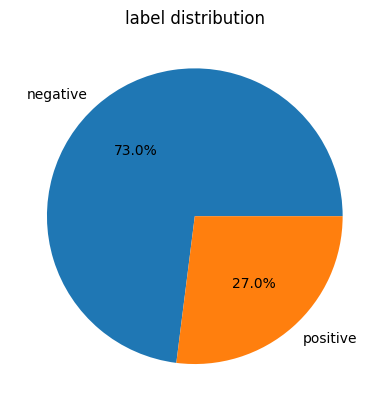

Label distribution:  {1: 1885, 0: 697}
Val


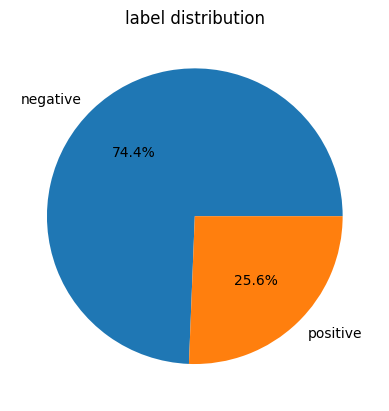

Label distribution:  {1: 412, 0: 142}
Test


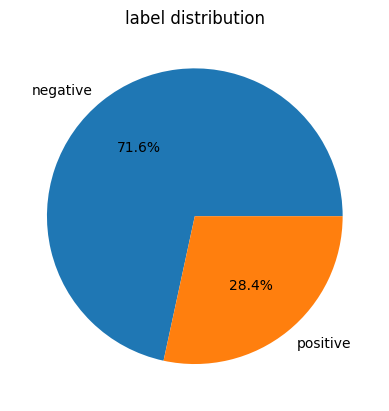

Label distribution:  {1: 396, 0: 157}


In [12]:
def describe_label_distribution(label):
    """plot the distribution of label"""
    plt.pie(label, labels=['negative','positive'], autopct='%1.1f%%')
    plt.title('label distribution')
    plt.show()
    print('Label distribution: ', label.to_dict())


print('Train')
describe_label_distribution(df_train.label.value_counts())
print('Val')
describe_label_distribution(df_val.label.value_counts())
print('Test')
describe_label_distribution(df_test.label.value_counts())

In [13]:
tokenizer = RegexpTokenizer(r'\w+')

def extract_content_and_clean(text):
    """Find all content in tags"""
    tokens = tokenizer.tokenize(text)
    return ' '.join(tokens).lower()

In [14]:
df_train['reviewClean'] = df_train.review.apply(extract_content_and_clean)
df_temp['reviewClean'] = df_temp.review.apply(extract_content_and_clean)
df_val['reviewClean'] = df_val.review.apply(extract_content_and_clean)
df_test['reviewClean'] = df_test.review.apply(extract_content_and_clean)

In [15]:
stemmer = PorterStemmer()

def stemming(s):
    return s.split()

In [16]:
df_train['tokens'] = df_train.reviewClean.apply(stemming)
df_temp['tokens'] = df_temp.reviewClean.apply(stemming)
df_val['tokens'] = df_val.reviewClean.apply(stemming)
df_test['tokens'] = df_test.reviewClean.apply(stemming)

In [17]:
count = CountVectorizer(
    tokenizer=lambda x: x, stop_words='english', lowercase=False, max_features=100)

In [18]:
count.fit(df_train.tokens)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


CountVectorizer(lowercase=False, max_features=100, stop_words='english',
                tokenizer=<function <lambda> at 0x7f8e8e4fb820>)

In [19]:
X_train = count.transform(df_train.tokens).toarray()
X_val = count.transform(df_val.tokens).toarray()
X_test = count.transform(df_test.tokens).toarray()

In [20]:
y_train = df_train.label
y_val = df_val.label
y_test = df_test.label

In [21]:
iterations = np.arange(10, 101, 10)

train_accs = []
test_accs = []

for iteration in iterations:
    svm = SVC(probability=True, C=100, kernel='linear', max_iter=iteration)
    svm.fit(X_train, y_train)
    train_accs.append(svm.score(X_train, y_train))
    test_accs.append(svm.score(X_test, y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=30).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=40).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing

In [22]:
# print acc of training data
train_accs

[0.6897753679318358,
 0.6789310611928737,
 0.6494965143299768,
 0.6580170410534469,
 0.5879163439194423,
 0.6196746707978311,
 0.6196746707978311,
 0.6196746707978311,
 0.6196746707978311,
 0.6196746707978311]

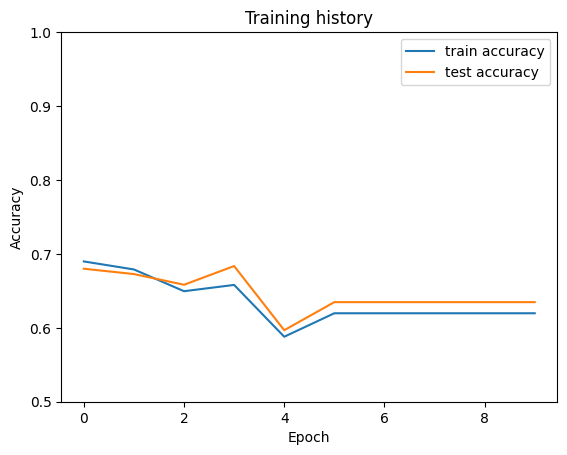

In [23]:
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='test accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

In [24]:
svm = SVC(probability=True, C=100, kernel='linear', max_iter=100)
svm.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=100, kernel='linear', max_iter=100, probability=True)

In [25]:
y_pred = svm.predict(X_test)

In [26]:
class_name = ['negative','positive']

In [27]:
# Reporting on indicators of classification results
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    negative       0.29      0.20      0.24       157
    positive       0.72      0.81      0.76       396

    accuracy                           0.63       553
   macro avg       0.51      0.50      0.50       553
weighted avg       0.60      0.63      0.61       553



Test


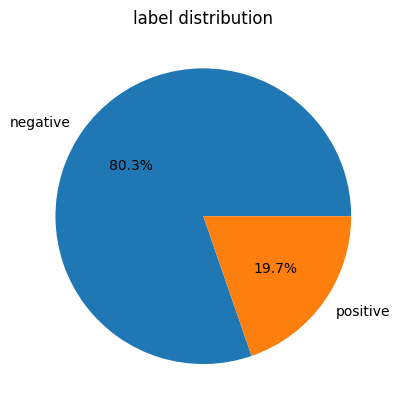

Label distribution:  {1: 444, 0: 109}
Train


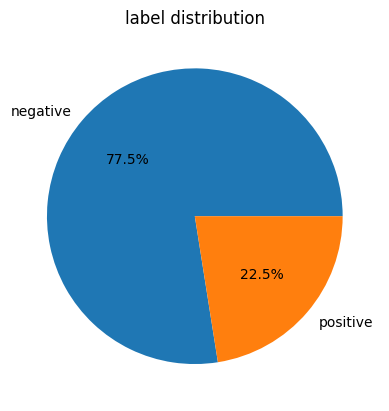

Label distribution:  {1: 2001, 0: 581}


In [30]:
# test prediction
print('Test')
labels = pd.value_counts(y_pred)
describe_label_distribution(labels)

# train prediction
print('Train')
labels = pd.value_counts(svm.predict(X_train))
describe_label_distribution(labels)

In [ ]:
# Dichotomous confusion matrix plotting and ROC curve plotting
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives','Negatives']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh))
    
    plt.subplot(121)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
    
    #2 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(122)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)
    
    return results

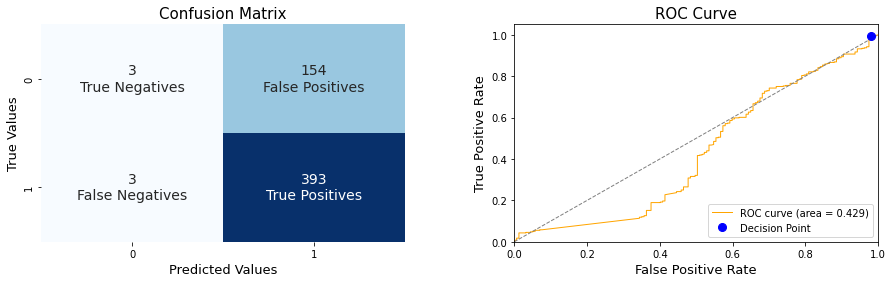

Precision: 0.718 | Recall: 0.992 | F1 Score: 0.834 | AUC: 0.429


{'Precision': 0.7184643510054844,
 'Recall': 0.9924242424242424,
 'F1 Score': 0.8335100742311771,
 'AUC': 0.42868172167535223}

In [ ]:
binary_performances(
    y_test, 
    svm.predict_proba(X_test)[:, 1], thresh=0.5, labels=['Positives','Negatives'])